# Convolutional Neural Networks

## Project: Write an Algorithm for a Fruits Identification App 


<a id='step0'></a>
## Step 0: Import Datasets

In [10]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
# load filenames for human and dog images

fruit_files = np.array(glob("data/*/*/*"))

# print number of images in each dataset
print('There are %d total fruit images.' % len(fruit_files))

There are 19137 total fruit images.


---
<a id='step2'></a>
## Step 1: Detect Fruits

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [ ]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)
# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\SHAHRIAR/.cache\torch\checkpoints\vgg16-397923af.pth


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

In [13]:
from PIL import Image
import torchvision.transforms as transforms


def load_image(img_path):
    ''' Load in and transform an image'''
    image = Image.open(img_path).convert('RGB')
    

     # VGG-16 Takes 224x224 images as input, so we resize all of them and convert data to a normalized torch.FloatTensor    
    in_transform = transforms.Compose([
                        transforms.Resize(224),
                        transforms.CenterCrop(224),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

## Image Processing 

In [14]:
import os
from torchvision import datasets
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20


data_dir = 'data/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')
valid_dir = os.path.join(data_dir, 'valid/')


transform = { 'train'}

data_transforms = {
    'train' : transforms.Compose([transforms.Resize(224),
                                  transforms.CenterCrop(224),
                                  transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                  transforms.RandomRotation(10),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]),

    'valid' : transforms.Compose([transforms.Resize(224),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])]),
    'test' : transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])}


image_datasets = {'train' : datasets.ImageFolder(root=train_dir,transform=data_transforms['train']),
                  'valid' : datasets.ImageFolder(root=valid_dir,transform=data_transforms['valid']),
                  'test' : datasets.ImageFolder(root=test_dir,transform=data_transforms['test'])}




loaders_scratch = {'train' : torch.utils.data.DataLoader(image_datasets['train'],batch_size = batch_size, num_workers = num_workers, shuffle=True),
                    'valid' : torch.utils.data.DataLoader(image_datasets['valid'],batch_size = batch_size, num_workers = num_workers),
                    'test' : torch.utils.data.DataLoader(image_datasets['test'],batch_size = batch_size, num_workers = num_workers)}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes
n_classes = len(class_names)

print( len(class_names))
print( len(image_datasets['train']))

print( len(image_datasets['valid']))

print( len(image_datasets['test']))

29
14336
277
4524



- I resized the images to `224X224` using `transforms.Resize(224)` to avoid the bias, the long time, and to save memory size in case of the big images size.
- Yes, as the dataset size is small so I decided to augment the dataset through randomly flip using `transforms.RandomHorizontalFlip()` and images rotation using `transforms.RandomRotation(10)` functions.



- As the input is RGB image cropped into `224x224` pixel and the depth is 3 (3 colors), we will have our input with the shape of `3x224x224`
- The desired no. of output is the same as no. of classes (here we have 133 classes in our images datasets).

- I created 3 convolutional layers with `relu activation function` and one max pooling layer(2,2), the first layer takes (3,224,224) input and converted it into a depth of 16 layers, the filter used was 3x3 with stride of 1 and padding of 1 in order to not get rid of edges:
  - first convolutional layer (sees 32x32x3 image tensor).
  - second convolutional layer (sees 16x16x16 tensor).
  - third convolutional layer (sees 8x8x32 tensor).
  - one pool layer (2,2) was used in order to reduce the size of the images to half.
  
- Then flatten image input using `view function` to reshape the tensor.
- Then, two full connected Linear layers with `relu activation function` were added, and dropout layers for the hidden layers with a percentage of 25% to avoid the bias:
  - first linear layer (64 * 28 * 28 -> 500).
  - second linear layer (500 -> 133), as the output classes is 133.

---
<a id='step4'></a>
Create a CNN to Classify Dog Breeds (using Transfer Learning)

We will now use transfer learning to create a CNN that can identify fruits from images. 

Specify Data Loaders for the fruits Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [15]:
## TODO: Specify data loaders
loaders_transfer = loaders_scratch

In [16]:
print(VGG16)
print(VGG16.classifier[6].in_features) 
print(VGG16.classifier[6].out_features)

NameError: name 'VGG16' is not defined

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [3]:
import torchvision.models as models
import torch.nn as nn


## TODO: Specify model architecture 

# Load the pretrained model from pytorch
model_transfer = VGG16

# Freeze training for all "features" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False

n_inputs = model_transfer.classifier[6].in_features

# add last linear layer (n_inputs -> 29 classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 29)

model_transfer.classifier[6] = last_layer


if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\SHAHRIAR/.cache\torch\checkpoints\vgg16-397923af.pth


KeyboardInterrupt: 


- Pre-trained modules are well trained to extract patterns and features very well.
- I chose to load the VGG16 models as transfer learning. I checked the structure then freeze training for all "features" layers because if I changed it will take a long time. I changed the last linear layer output to be 29 classes to fit with our classification output. Then train the classifier to get a good result for our application.

## Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [15]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [16]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            ###
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item()*data.size(0)
            ###
            
        ######################    
        # validate the model #
        ######################
        model.eval()

        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
            ###
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            ###
        train_loss = train_loss/len(loaders['train'].dataset) ###
        valid_loss = valid_loss/len(loaders['valid'].dataset) ###

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model

In [17]:
# train the model
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
# model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 0.980240 	Validation Loss: 0.367060
Validation loss decreased (inf --> 0.367060).  Saving model ...
Epoch: 2 	Training Loss: 0.166574 	Validation Loss: 0.205601
Validation loss decreased (0.367060 --> 0.205601).  Saving model ...
Epoch: 3 	Training Loss: 0.090924 	Validation Loss: 0.139784
Validation loss decreased (0.205601 --> 0.139784).  Saving model ...
Epoch: 4 	Training Loss: 0.062409 	Validation Loss: 0.110834
Validation loss decreased (0.139784 --> 0.110834).  Saving model ...
Epoch: 5 	Training Loss: 0.045294 	Validation Loss: 0.098620
Validation loss decreased (0.110834 --> 0.098620).  Saving model ...
Epoch: 6 	Training Loss: 0.037691 	Validation Loss: 0.080409
Validation loss decreased (0.098620 --> 0.080409).  Saving model ...
Epoch: 7 	Training Loss: 0.028178 	Validation Loss: 0.072097
Validation loss decreased (0.080409 --> 0.072097).  Saving model ...
Epoch: 8 	Training Loss: 0.023889 	Validation Loss: 0.059521
Validation loss decreased (0.07209

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [2]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

NameError: name 'model_transfer' is not defined

In [18]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [19]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.036761


Test Accuracy: 99% (4491/4524)


### Predict fruit with the Model

Write a function that takes an image path as input and returns the fruit name that is predicted by the model.  

In [27]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[0:].replace("_", " ") for item in image_datasets['train'].classes]


def predict_fruit_transfer(img_path):
    # load the image and return the predicted fruit

    image = load_image(img_path)
    if use_cuda:
        image = image.cuda()
    predict = model_transfer(image)
    predict = predict.data.cpu().argmax()
    
    return class_names[predict]

In [33]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def display_img(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.show()
    


def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    display_img(img_path)
    predicted_breed = predict_fruit_transfer (img_path)
    
    return print ('the predicted fruit is:', predicted_breed)


## Visualizing Output

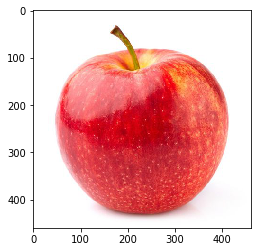

the predicted fruit is: Apple Red 1


In [44]:
file = 'img/5.jpg'
run_app(file)

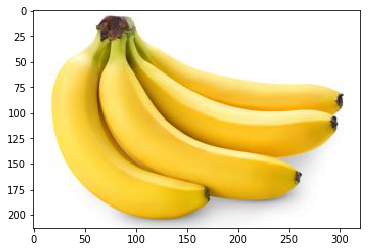

the predicted fruit is: Banana


In [43]:
file = 'img/3.jpg'
run_app(file)

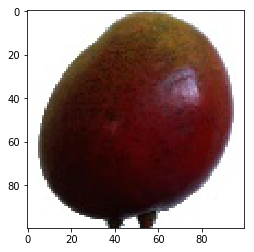

the predicted fruit is: Mango Red


In [40]:
file = 'img/4.jpg'
run_app(file)